In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

print('Libraries imported.')

Libraries imported.


#### From NYC Health's Github, we can find New York City's Covid Data organized by Modified ZCTA which is a Census version of Zip Codes. We will save this raw data into df_COVID_raw.

In [2]:
NYC_Health_url = "https://raw.githubusercontent.com/nychealth/coronavirus-data/master/data-by-modzcta.csv"
df_COVID_raw = pd.read_csv(NYC_Health_url, error_bad_lines=False)

#### Then we will filter out the raw data for just the borough of Manhattan and save this in a new dataframe called df_COVID_manhattan.

In [3]:
df_COVID_manhattan = df_COVID_raw[df_COVID_raw['BOROUGH_GROUP'] == "Manhattan"]
df_COVID_manhattan.head()

,MODIFIED_ZCTA,NEIGHBORHOOD_NAME,BOROUGH_GROUP,COVID_CASE_COUNT,COVID_CASE_RATE,POP_DENOMINATOR,COVID_DEATH_COUNT,COVID_DEATH_RATE,PERCENT_POSITIVE,TOTAL_COVID_TESTS
0,10001,Chelsea/NoMad/West Chelsea,Manhattan,440,1867.33,23563.03,26,110.34,6.89,6387
1,10002,Chinatown/Lower East Side,Manhattan,1324,1724.96,76755.41,161,209.76,8.01,16521
2,10003,East Village/Gramercy/Greenwich Village,Manhattan,537,998.11,53801.62,35,65.05,3.72,14448
3,10004,Financial District,Manhattan,40,1095.71,3650.61,1,27.39,5.11,783
4,10005,Financial District,Manhattan,94,1119.57,8396.11,2,23.82,4.74,1985


#### We can see that one issue with this data right now is the lack of longitude and latitude data for each of the modified ZCTA as the coordinates are a requirement for the Foursquare API. So in order to fix this issue, we need to find data from the US Census which provides longitude and latitude coordinates for Zip Codes.

In [4]:
USA_ZIP_Coordinates_URL = "https://gist.githubusercontent.com/erichurst/7882666/raw/5bdc46db47d9515269ab12ed6fb2850377fd869e/US%2520Zip%2520Codes%2520from%25202013%2520Government%2520Data"
USA_ZIP_Coordinates = pd.read_csv(USA_ZIP_Coordinates_URL, error_bad_lines=False)
USA_ZIP_Coordinates.head()

,ZIP,LAT,LNG
0,601,18.180555,-66.749961
1,602,18.361945,-67.175597
2,603,18.455183,-67.119887
3,606,18.158345,-66.932911
4,610,18.295366,-67.125135


#### Now that we have the zip code with their coordinates, we can merge these two dataframes together. Also note how ZIP is recorded as a integer as 00601 is displaying as 601 here, but fortunately since zip codes in Manhattan all start with 1, this will not be an issue for us.

In [5]:
df_merged = pd.merge(df_COVID_manhattan, USA_ZIP_Coordinates, left_on = 'MODIFIED_ZCTA', right_on = 'ZIP')
df_merged.head()

,MODIFIED_ZCTA,NEIGHBORHOOD_NAME,BOROUGH_GROUP,COVID_CASE_COUNT,COVID_CASE_RATE,POP_DENOMINATOR,COVID_DEATH_COUNT,COVID_DEATH_RATE,PERCENT_POSITIVE,TOTAL_COVID_TESTS,ZIP,LAT,LNG
0,10001,Chelsea/NoMad/West Chelsea,Manhattan,440,1867.33,23563.03,26,110.34,6.89,6387,10001,40.750633,-73.997177
1,10002,Chinatown/Lower East Side,Manhattan,1324,1724.96,76755.41,161,209.76,8.01,16521,10002,40.715775,-73.986212
2,10003,East Village/Gramercy/Greenwich Village,Manhattan,537,998.11,53801.62,35,65.05,3.72,14448,10003,40.731829,-73.989181
3,10004,Financial District,Manhattan,40,1095.71,3650.61,1,27.39,5.11,783,10004,40.688630,-74.018244
4,10005,Financial District,Manhattan,94,1119.57,8396.11,2,23.82,4.74,1985,10005,40.706027,-74.008835


#### Finally, we will clean up our merged dataframe by removing some of the redundant columns and renaming the rest for clarity.

In [6]:
df_merged.drop(['BOROUGH_GROUP', 'ZIP'], axis = 1, inplace = True)
df_merged.rename(columns = {'MODIFIED_ZCTA':'ZIP','NEIGHBORHOOD_NAME':'NEIGHBORHOOD', 'LAT':"LATITUDE", "LNG":"LONGITUDE"}, inplace = True)
df_merged.head()

,ZIP,NEIGHBORHOOD,COVID_CASE_COUNT,COVID_CASE_RATE,POP_DENOMINATOR,COVID_DEATH_COUNT,COVID_DEATH_RATE,PERCENT_POSITIVE,TOTAL_COVID_TESTS,LATITUDE,LONGITUDE
0,10001,Chelsea/NoMad/West Chelsea,440,1867.33,23563.03,26,110.34,6.89,6387,40.750633,-73.997177
1,10002,Chinatown/Lower East Side,1324,1724.96,76755.41,161,209.76,8.01,16521,40.715775,-73.986212
2,10003,East Village/Gramercy/Greenwich Village,537,998.11,53801.62,35,65.05,3.72,14448,40.731829,-73.989181
3,10004,Financial District,40,1095.71,3650.61,1,27.39,5.11,783,40.688630,-74.018244
4,10005,Financial District,94,1119.57,8396.11,2,23.82,4.74,1985,40.706027,-74.008835


#### With our data in place, let's first explore it a bit.

In [7]:
df_merged.describe()

,ZIP,COVID_CASE_COUNT,COVID_CASE_RATE,POP_DENOMINATOR,COVID_DEATH_COUNT,COVID_DEATH_RATE,PERCENT_POSITIVE,TOTAL_COVID_TESTS,LATITUDE,LONGITUDE
count,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.00000,44.000000,44.000000,44.000000
mean,10039.090909,646.295455,1663.716136,36635.079318,57.113636,138.167727,6.80750,9187.909091,40.767135,-73.973588
std,58.083668,502.383416,641.191304,22461.194791,53.906990,95.000760,2.70758,5743.022876,0.045302,0.027682
min,10001.000000,40.000000,665.370000,3457.770000,0.000000,0.000000,3.60000,783.000000,40.688630,-74.018244
25%,10012.750000,284.000000,1124.677500,21698.375000,20.500000,66.385000,4.61250,5147.500000,40.730471,-73.997402
50%,10025.500000,559.000000,1496.965000,31707.510000,41.500000,113.895000,5.80000,8675.000000,40.763264,-73.976362
75%,10036.250000,833.500000,1981.415000,54685.635000,69.750000,196.882500,9.43250,14162.000000,40.798489,-73.950037
max,10282.000000,2036.000000,3285.250000,92333.470000,213.000000,395.040000,12.06000,26233.000000,40.867076,-73.924312


#### Of these data, I am particularly interested in COVID_CASE_COUNT, COVID_CASE_RATE, POP_DENOMINATOR, PERCENT_POSITIVE, and TOTAL_COVID_TESTS, so let us clean the data a bit more and review the statistics again.

In [8]:
df_merged.drop(['COVID_DEATH_COUNT', 'COVID_DEATH_RATE'], axis = 1, inplace = True)
df_merged.rename(columns = {'COVID_CASE_COUNT':'CASES','COVID_CASE_RATE':'CASE_RATE', 'POP_DENOMINATOR':"POPULATION"}, inplace = True)
df_merged.head()

,ZIP,NEIGHBORHOOD,CASES,CASE_RATE,POPULATION,PERCENT_POSITIVE,TOTAL_COVID_TESTS,LATITUDE,LONGITUDE
0,10001,Chelsea/NoMad/West Chelsea,440,1867.33,23563.03,6.89,6387,40.750633,-73.997177
1,10002,Chinatown/Lower East Side,1324,1724.96,76755.41,8.01,16521,40.715775,-73.986212
2,10003,East Village/Gramercy/Greenwich Village,537,998.11,53801.62,3.72,14448,40.731829,-73.989181
3,10004,Financial District,40,1095.71,3650.61,5.11,783,40.688630,-74.018244
4,10005,Financial District,94,1119.57,8396.11,4.74,1985,40.706027,-74.008835


#### Let's take a look at the descriptive statistics of our data.

In [9]:
df_merged.describe()

,ZIP,CASES,CASE_RATE,POPULATION,PERCENT_POSITIVE,TOTAL_COVID_TESTS,LATITUDE,LONGITUDE
count,44.000000,44.000000,44.000000,44.000000,44.00000,44.000000,44.000000,44.000000
mean,10039.090909,646.295455,1663.716136,36635.079318,6.80750,9187.909091,40.767135,-73.973588
std,58.083668,502.383416,641.191304,22461.194791,2.70758,5743.022876,0.045302,0.027682
min,10001.000000,40.000000,665.370000,3457.770000,3.60000,783.000000,40.688630,-74.018244
25%,10012.750000,284.000000,1124.677500,21698.375000,4.61250,5147.500000,40.730471,-73.997402
50%,10025.500000,559.000000,1496.965000,31707.510000,5.80000,8675.000000,40.763264,-73.976362
75%,10036.250000,833.500000,1981.415000,54685.635000,9.43250,14162.000000,40.798489,-73.950037
max,10282.000000,2036.000000,3285.250000,92333.470000,12.06000,26233.000000,40.867076,-73.924312


#### Next, we can look at the correlations between our COVID related data

In [10]:
df_merged[['CASES', 'CASE_RATE', 'POPULATION', 'PERCENT_POSITIVE', 'TOTAL_COVID_TESTS']].corr()

,CASES,CASE_RATE,POPULATION,PERCENT_POSITIVE,TOTAL_COVID_TESTS
CASES,1.000000,0.656516,0.857166,0.612281,0.821477
CASE_RATE,0.656516,1.000000,0.261408,0.958486,0.230742
POPULATION,0.857166,0.261408,1.000000,0.207643,0.983726
PERCENT_POSITIVE,0.612281,0.958486,0.207643,1.000000,0.137327
TOTAL_COVID_TESTS,0.821477,0.230742,0.983726,0.137327,1.000000


#### From the correlation figures, we can note that not suprisingly, cases correlated highly to population and total number of covid tests. Case rate correlated highly with positive rate but poorly to population and total tests which suggests that populations is not a indication of positive rate. This could be either an interesting observation or an inherent issue with testing as total test correlates highly with population but poorly with both the case rate and positive percentage.

#### Now let's plot out our data so we can better visualize them.

In [11]:
%%capture
! pip install seaborn

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

#### First we can plot a histogram of the all the case rates just to get a feel for the distribution of case rates in Manhattan.

(array([ 3., 11.,  7.,  4.,  8.,  2.,  2.,  3.,  3.,  1.]),
 array([ 665.37 ,  927.358, 1189.346, 1451.334, 1713.322, 1975.31 ,
        2237.298, 2499.286, 2761.274, 3023.262, 3285.25 ]),
 <a list of 10 Patch objects>)

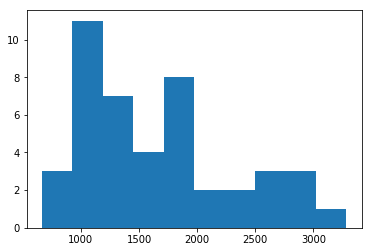

In [12]:
plt.hist(df_merged['CASE_RATE'])

#### From the above graph it seems that most of the case rates are concentrated between 927 and 1189, but this do not tell us much about the case rate by zip code so let us plot that next with a bar graph to see if we can find zip codes with abnormally high case rates as the skewness on the histogram here suggests the existance of some extreme case rates.

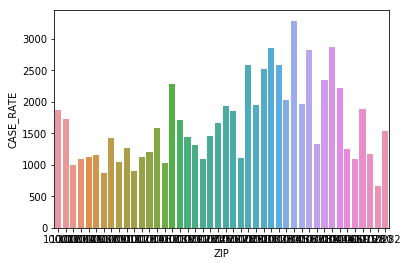

In [13]:
sns.barplot(data = df_merged, x = 'ZIP', y = "CASE_RATE")

#### So since zip codes that are closer in numerical value are also close in distance, we can basically try to break this data down into clusters and we can see a few relatively high clusters in the pink, green, and purple bars.

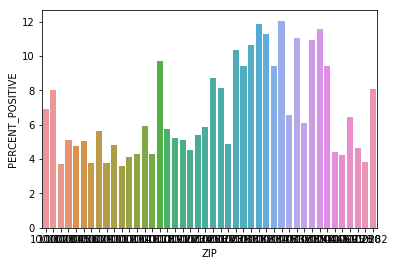

In [14]:
sns.barplot(data = df_merged, x = "ZIP", y = 'PERCENT_POSITIVE')

#### Finally just to confirm our findings, we used the percent positive to look again to see if those higher case counts are actually areas with higher percent positive. And from this graph, we can indeed confirm there are certain neighborhoods that have exceedingly high percent positive. Now we just need to use the Foursquare API to cluster the zip codes by the venues within them to see if we see a better trend within similar neighborhoods.

#### With our data in place, it is time to use the Foursquare API to pull up venue data for each of our zip codes using the given latitude and longitude.

In [15]:
CLIENT_ID = '5NOCFXQ4JX4B1WS3TGEVMVES2S5K2AK5J5ZNN0MQBQCMWP0O'
CLIENT_SECRET = 'Z00OD4CCEUUPFPWA5WDG2SYHTQHQOH5XZDAZCLIU4HCUQBAC'
VERSION = '20200802'

#### We will first take a look at the first zip code on our list to get familar with the Foursquare API.

In [16]:
df_merged.loc[0, 'ZIP']
zip_latitude = df_merged.loc[0, 'LATITUDE']
zip_longitude = df_merged.loc[0, 'LONGITUDE']
neighborhood_name = df_merged.loc[0, 'NEIGHBORHOOD']

#### Now that we have the information for the first zip code, let us take a look at the top 100 venues in a 500 meter radius.

In [17]:
LIMIT = 100
radius = 500

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    zip_latitude, 
    zip_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=5NOCFXQ4JX4B1WS3TGEVMVES2S5K2AK5J5ZNN0MQBQCMWP0O&client_secret=Z00OD4CCEUUPFPWA5WDG2SYHTQHQOH5XZDAZCLIU4HCUQBAC&v=20200802&ll=40.750633,-73.99717700000001&radius=500&limit=100'

In [18]:
results = requests.get(url).json()

#### Below is the get_category_type function from the Foursquare API lab. It will help us categorize our top 100 venues by their type.

In [19]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### Now we can utilize this function on the result json that we pulled earlier and check to see if everything is working as intended.

In [20]:
from pandas.io.json import json_normalize

venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,New York Pizza Suprema,Pizza Place,40.750124,-73.994992
1,Bluestone Lane,Coffee Shop,40.752068,-73.998848
2,You Should Be Dancing…..! / Club 412,Dance Studio,40.750306,-73.994743
3,Panda Express,Chinese Restaurant,40.750301,-73.994707
4,Music Choice,Music Venue,40.752632,-73.994585


#### Everything seems to be working as intended so let us combine all of this into a single function so we can apply it on our entire dataframe.

In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['ZIP', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Let's run the function with our dataframe

In [22]:
manhattan_venues = getNearbyVenues(names = df_merged['ZIP'], latitudes = df_merged['LATITUDE'], longitudes = df_merged['LONGITUDE'])

10001
10002
10003
10004
10005
10006
10007
10009
10010
10011
10012
10013
10014
10016
10017
10018
10019
10021
10022
10023
10024
10025
10026
10027
10028
10029
10030
10031
10032
10033
10034
10035
10036
10037
10038
10039
10040
10044
10065
10069
10075
10128
10280
10282


#### Now let's check out our new dataframe with all the top venues and their categories.

In [23]:
print(manhattan_venues.shape)
manhattan_venues.head()

(3461, 7)


,ZIP,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,10001,40.750633,-73.997177,New York Pizza Suprema,40.750124,-73.994992,Pizza Place
1,10001,40.750633,-73.997177,Bluestone Lane,40.752068,-73.998848,Coffee Shop
2,10001,40.750633,-73.997177,You Should Be Dancing…..! / Club 412,40.750306,-73.994743,Dance Studio
3,10001,40.750633,-73.997177,Panda Express,40.750301,-73.994707,Chinese Restaurant
4,10001,40.750633,-73.997177,Music Choice,40.752632,-73.994585,Music Venue


#### We can break this down farther by looking at the number of venues returned for each neighborhood.

In [24]:
manhattan_venues.groupby('ZIP').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
ZIP,,,,,,
10001,80,80,80,80,80,80
10002,100,100,100,100,100,100
10003,100,100,100,100,100,100
10004,38,38,38,38,38,38
10005,100,100,100,100,100,100
10006,100,100,100,100,100,100
10007,100,100,100,100,100,100
10009,100,100,100,100,100,100
10010,100,100,100,100,100,100


#### Let's find out how many unique categories can be curated from all the returned venues

In [25]:
print('There are {} uniques categories.'.format(len(manhattan_venues['Venue Category'].unique())))

There are 335 uniques categories.


#### Now let's use one hot encoding to get a new data frame where we have all the venue categories for each zip code

In [26]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['ZIP'] = manhattan_venues['ZIP'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,ZIP,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Historic Site,History Museum,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Island,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Peking Duck Restaurant,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Physical Therapist,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Puerto Rican Restaurant,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Sho

In [27]:
manhattan_onehot.shape

(3461, 336)

In [28]:
manhattan_grouped = manhattan_onehot.groupby('ZIP').mean().reset_index()
manhattan_grouped

,ZIP,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Historic Site,History Museum,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Island,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Peking Duck Restaurant,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Physical Therapist,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Puerto Rican Restaurant,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Sho

In [29]:
manhattan_grouped.shape

(44, 336)

#### Now we can limit the number of venues for each location to the top 10 and create a list for all our zip codes.

In [30]:
num_top_venues = 5

for hood in manhattan_grouped['ZIP']:
    print("----"+str(hood)+"----")
    temp = manhattan_grouped[manhattan_grouped['ZIP'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----10001----
          venue  freq
0  Dance Studio  0.06
1  Burger Joint  0.05
2         Hotel  0.05
3   Salad Place  0.04
4   Coffee Shop  0.04


----10002----
                venue  freq
0  Mexican Restaurant  0.07
1        Cocktail Bar  0.05
2         Coffee Shop  0.05
3  Chinese Restaurant  0.04
4                 Bar  0.04


----10003----
                      venue  freq
0       Japanese Restaurant  0.06
1              Dessert Shop  0.05
2            Ice Cream Shop  0.05
3  Mediterranean Restaurant  0.04
4             Grocery Store  0.04


----10004----
                      venue  freq
0                Food Truck  0.11
1  Bike Rental / Bike Share  0.08
2            Ice Cream Shop  0.05
3                Food Stand  0.05
4                  Fountain  0.03


----10005----
                  venue  freq
0           Coffee Shop  0.08
1   American Restaurant  0.04
2  Gym / Fitness Center  0.04
3           Pizza Place  0.04
4          Cocktail Bar  0.04


----10006----
           venue  

#### Definte a function to compile the above list into a final data drame for all the zip codes.

In [31]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [32]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['ZIP']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['ZIP'] = manhattan_grouped['ZIP']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,ZIP,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,10001,Dance Studio,Hotel,Burger Joint,Salad Place,Coffee Shop
1,10002,Mexican Restaurant,Coffee Shop,Cocktail Bar,Chinese Restaurant,Bar
2,10003,Japanese Restaurant,Dessert Shop,Ice Cream Shop,Grocery Store,Mediterranean Restaurant
3,10004,Food Truck,Bike Rental / Bike Share,Food Stand,Ice Cream Shop,Pizza Place
4,10005,Coffee Shop,Cocktail Bar,American Restaurant,Pizza Place,Gym / Fitness Center


#### Now we can use the K Means Clustering to find separate our zip codes based on their top ten most common venues. I will start with K=5 and see if the result makes sense and adjust accordingly.

In [33]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 10

manhattan_grouped_clustering = manhattan_grouped.drop('ZIP', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 1, 3, 0, 3, 4, 3, 1, 3, 3], dtype=int32)

In [34]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = df_merged

manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('ZIP'), on='ZIP')

manhattan_merged

,ZIP,NEIGHBORHOOD,CASES,CASE_RATE,POPULATION,PERCENT_POSITIVE,TOTAL_COVID_TESTS,LATITUDE,LONGITUDE,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,10001,Chelsea/NoMad/West Chelsea,440,1867.33,23563.03,6.89,6387,40.750633,-73.997177,3,Dance Studio,Hotel,Burger Joint,Salad Place,Coffee Shop
1,10002,Chinatown/Lower East Side,1324,1724.96,76755.41,8.01,16521,40.715775,-73.986212,1,Mexican Restaurant,Coffee Shop,Cocktail Bar,Chinese Restaurant,Bar
2,10003,East Village/Gramercy/Greenwich Village,537,998.11,53801.62,3.72,14448,40.731829,-73.989181,3,Japanese Restaurant,Dessert Shop,Ice Cream Shop,Grocery Store,Mediterranean Restaurant
3,10004,Financial District,40,1095.71,3650.61,5.11,783,40.688630,-74.018244,0,Food Truck,Bike Rental / Bike Share,Food Stand,Ice Cream Shop,Pizza Place
4,10005,Financial District,94,1119.57,8396.11,4.74,1985,40.706027,-74.008835,3,Coffee Shop,Cocktail Bar,American Restaurant,Pizza Place,Gym / Fitness Center
5,10006,Financial District,40,1156.81,3457.77,5.05,792,40.709614,-74.012954,4,Hotel,Pizza Place,Coffee Shop,Memorial Site,Park
6,10007,TriBeCa,72,872.76,8249.73,3.77,1909,40.713848,-74.007755,3,Coffee Shop,Sandwich Place,Park,Café,Gym
7,10009,Alphabet City/East Village/Stuyvesant Town-Coo...,835,1421.33,58747.99,5.61,14874,40.726399,-73.978631,1,Cocktail Bar,Bar,Coffee Shop,Mexican Restaurant,Pizza Place
8,10010,Flatiron/Gramercy/Kips Bay,336,1037.94,32371.86,3.79,8860,40.739065,-73.982255,3,Indian Restaurant,Italian Restaurant,Bar,American Restaurant,Coffee Shop
9,10011,Chelsea,628,1268.67,49500.52,4.83,13005,40.742039,-74.000620,3,Coffee Shop,American Restaurant,Yoga Studio,Grocery Store,New American Restaurant


#### The clusters is mainly focused on the first three clusters with only one zip code for cluster 4 and 5. And interestingly enough, those two clusters are relatively close to each other as they are zip codes 10037 and 10040. Now perhaps more clusters would create a better spread, so let's try to change K to 8 and try again.

In [47]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(2, manhattan_merged.shape[1]))]]

,NEIGHBORHOOD,CASES,CASE_RATE,POPULATION,PERCENT_POSITIVE,TOTAL_COVID_TESTS,LATITUDE,LONGITUDE,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
3,Financial District,40,1095.71,3650.61,5.11,783,40.68863,-74.018244,0,Food Truck,Bike Rental / Bike Share,Food Stand,Ice Cream Shop,Pizza Place


In [48]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(2, manhattan_merged.shape[1]))]]

,NEIGHBORHOOD,CASES,CASE_RATE,POPULATION,PERCENT_POSITIVE,TOTAL_COVID_TESTS,LATITUDE,LONGITUDE,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Chinatown/Lower East Side,1324,1724.96,76755.41,8.01,16521,40.715775,-73.986212,1,Mexican Restaurant,Coffee Shop,Cocktail Bar,Chinese Restaurant,Bar
7,Alphabet City/East Village/Stuyvesant Town-Coo...,835,1421.33,58747.99,5.61,14874,40.726399,-73.978631,1,Cocktail Bar,Bar,Coffee Shop,Mexican Restaurant,Pizza Place
26,Central Harlem (North),571,1947.35,29321.91,9.44,6049,40.818267,-73.942856,1,Deli / Bodega,Southern / Soul Food Restaurant,Sandwich Place,Grocery Store,Fried Chicken Joint


In [49]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(2, manhattan_merged.shape[1]))]]

,NEIGHBORHOOD,CASES,CASE_RATE,POPULATION,PERCENT_POSITIVE,TOTAL_COVID_TESTS,LATITUDE,LONGITUDE,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
10,Greenwich Village/SoHo,217,904.88,23981.20,3.60,6030,40.725581,-73.998078,2,Italian Restaurant,Clothing Store,Sushi Restaurant,Men's Store,Mediterranean Restaurant
12,Hudson Square/Meatpacking District/West Village,375,1208.00,31043.16,4.32,8687,40.734012,-74.006746,2,Italian Restaurant,New American Restaurant,Coffee Shop,Cocktail Bar,American Restaurant
15,Hell's Kitchen/Midtown Manhattan,217,2276.68,9531.44,9.74,2229,40.755319,-73.993114,2,Hotel,Theater,Coffee Shop,Burger Joint,Gym / Fitness Center
19,Lincoln Square,655,1086.69,60274.81,4.53,14468,40.775921,-73.982607,2,Italian Restaurant,Theater,Coffee Shop,American Restaurant,Gym / Fitness Center
23,Central Harlem (South)/Morningside Heights/Wes...,1183,1859.16,63631.04,8.16,14497,40.811407,-73.953060,2,Wine Shop,Shoe Store,Clothing Store,Kids Store,American Restaurant
32,Hell's Kitchen/Midtown Manhattan,516,1968.62,26211.25,6.56,7865,40.759260,-73.989860,2,Theater,Hotel,Burger Joint,Indie Theater,Gym / Fitness Center


In [38]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,NEIGHBORHOOD,PERCENT_POSITIVE,TOTAL_COVID_TESTS,LATITUDE,LONGITUDE,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Chelsea/NoMad/West Chelsea,6.89,6387,40.750633,-73.997177,3,Dance Studio,Hotel,Burger Joint,Salad Place,Coffee Shop
2,East Village/Gramercy/Greenwich Village,3.72,14448,40.731829,-73.989181,3,Japanese Restaurant,Dessert Shop,Ice Cream Shop,Grocery Store,Mediterranean Restaurant
4,Financial District,4.74,1985,40.706027,-74.008835,3,Coffee Shop,Cocktail Bar,American Restaurant,Pizza Place,Gym / Fitness Center
6,TriBeCa,3.77,1909,40.713848,-74.007755,3,Coffee Shop,Sandwich Place,Park,Café,Gym
8,Flatiron/Gramercy/Kips Bay,3.79,8860,40.739065,-73.982255,3,Indian Restaurant,Italian Restaurant,Bar,American Restaurant,Coffee Shop
9,Chelsea,4.83,13005,40.742039,-74.000620,3,Coffee Shop,American Restaurant,Yoga Studio,Grocery Store,New American Restaurant
11,Hudson Square/Little Italy/SoHo/TriBeCa,4.14,7903,40.720103,-74.004903,3,Coffee Shop,Gym / Fitness Center,Men's Store,American Restaurant,Spa
13,Kips Bay/Murray Hill/NoMad,5.90,14127,40.745224,-73.978297,3,Bar,Gym / Fitness Center,Indian Restaurant,Coffee Shop,Salad Place
14,East Midtown/Murray Hill,4.30,3859,40.752360,-73.972493,3,Coffee Shop,Japanese Restaurant,Burger Joint,Seafood Restaurant,Sandwich Place
16,Hell's Kitchen/Midtown Manhattan,5.74,12163,40.765823,-73.987169,3,Theater,Coffee Shop,Pizza Place,Mexican Restaurant,Wine Bar


In [50]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[1] + list(range(2, manhattan_merged.shape[1]))]]

,NEIGHBORHOOD,CASES,CASE_RATE,POPULATION,PERCENT_POSITIVE,TOTAL_COVID_TESTS,LATITUDE,LONGITUDE,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
5,Financial District,40,1156.81,3457.77,5.05,792,40.709614,-74.012954,4,Hotel,Pizza Place,Coffee Shop,Memorial Site,Park
37,Roosevelt Island,260,2222.17,11700.29,9.43,2756,40.761915,-73.949962,4,Bus Line,Pharmacy,Park,Scenic Lookout,Metro Station
39,Lincoln Square,69,1088.65,6338.13,4.25,1622,40.775906,-73.990358,4,Park,Gym / Fitness Center,Gym,Grocery Store,Pier
42,Battery Park City,64,665.37,9618.70,3.81,1681,40.708538,-74.016650,4,Park,Memorial Site,Hotel,Gym,Food Truck
43,Battery Park City,85,1541.13,5515.44,8.08,1052,40.716921,-74.015066,4,Park,Coffee Shop,Playground,Sandwich Place,Italian Restaurant


In [51]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 5, manhattan_merged.columns[[1] + list(range(2, manhattan_merged.shape[1]))]]

,NEIGHBORHOOD,CASES,CASE_RATE,POPULATION,PERCENT_POSITIVE,TOTAL_COVID_TESTS,LATITUDE,LONGITUDE,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
33,Central Harlem (North)/East Harlem,581,2813.61,20649.62,11.04,5264,40.812957,-73.937376,5,Seafood Restaurant,Library,Latin American Restaurant,Bookstore,Gym


In [52]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 6, manhattan_merged.columns[[1] + list(range(2, manhattan_merged.shape[1]))]]

,NEIGHBORHOOD,CASES,CASE_RATE,POPULATION,PERCENT_POSITIVE,TOTAL_COVID_TESTS,LATITUDE,LONGITUDE,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
35,Central Harlem (North)/Washington Heights (South),619,2339.6,26457.52,10.91,5672,40.830867,-73.936218,6,Deli / Bodega,Basketball Court,Jazz Club,Train Station,Donut Shop


In [53]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 7, manhattan_merged.columns[[1] + list(range(2, manhattan_merged.shape[1]))]]

,NEIGHBORHOOD,CASES,CASE_RATE,POPULATION,PERCENT_POSITIVE,TOTAL_COVID_TESTS,LATITUDE,LONGITUDE,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
27,Hamilton Heights/West Harlem,1523,2514.99,60556.93,10.67,14267,40.825288,-73.950045,7,Pizza Place,Coffee Shop,Chinese Restaurant,Café,Bar
29,Washington Heights (North)/Washington Heights ...,1528,2580.63,59210.43,11.27,13561,40.850545,-73.933983,7,Bakery,Pizza Place,Mobile Phone Shop,Mexican Restaurant,Deli / Bodega
30,Inwood/Washington Heights (North),870,2019.80,43073.65,9.45,9209,40.867076,-73.924312,7,Pizza Place,Wine Bar,Restaurant,Spanish Restaurant,Bank


In [54]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 8, manhattan_merged.columns[[1] + list(range(2, manhattan_merged.shape[1]))]]

,NEIGHBORHOOD,CASES,CASE_RATE,POPULATION,PERCENT_POSITIVE,TOTAL_COVID_TESTS,LATITUDE,LONGITUDE,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
25,East Harlem,2036,2582.40,78841.52,10.37,19628,40.791763,-73.943970,8,Mexican Restaurant,Bakery,Thai Restaurant,Deli / Bodega,Park
28,Washington Heights (South),1758,2858.88,61492.57,11.85,14834,40.838815,-73.942836,8,Mexican Restaurant,Pizza Place,Latin American Restaurant,Bar,Bookstore


In [55]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 9, manhattan_merged.columns[[1] + list(range(2, manhattan_merged.shape[1]))]]

,NEIGHBORHOOD,CASES,CASE_RATE,POPULATION,PERCENT_POSITIVE,TOTAL_COVID_TESTS,LATITUDE,LONGITUDE,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
36,Washington Heights (North),1288,2874.47,44808.28,11.59,11115,40.858305,-73.930549,9,Chinese Restaurant,Pizza Place,Seafood Restaurant,Park,Bar


In [65]:
cluster_df = manhattan_merged.groupby(['Cluster Labels']).mean()
cluster_df

,ZIP,CASES,CASE_RATE,POPULATION,PERCENT_POSITIVE,TOTAL_COVID_TESTS,LATITUDE,LONGITUDE
Cluster Labels,,,,,,,,
0,10004.000000,40.000000,1095.710000,3650.610000,5.110000,783.000000,40.688630,-74.018244
1,10013.666667,910.000000,1697.880000,54941.770000,7.686667,12481.333333,40.753480,-73.969233
2,10021.666667,527.166667,1550.671667,35778.816667,6.151667,8962.666667,40.760250,-73.987244
3,10028.047619,561.095238,1450.077143,37955.896190,5.556190,10038.666667,40.756898,-73.976390
4,10136.200000,103.600000,1334.826000,7326.066000,6.124000,1580.600000,40.734579,-73.996998
5,10037.000000,581.000000,2813.610000,20649.620000,11.040000,5264.000000,40.812957,-73.937376
6,10039.000000,619.000000,2339.600000,26457.520000,10.910000,5672.000000,40.830867,-73.936218
7,10032.666667,1307.000000,2371.806667,54280.336667,10.463333,12345.666667,40.847636,-73.936113
8,10030.500000,1897.000000,2720.640000,70167.045000,11.110000,17231.000000,40.815289,-73.943403


In [45]:
!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    ------------------------------------------------------------
                       

In [59]:
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          97 KB

The following NEW packages will be INSTALLED:

    geographiclib: 1.50-py_0          conda-forge
    geopy:         2.0.0-pyh9f0ad1d_0 conda-forge


geopy-2.0.0          | 63 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [60]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [61]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['LATITUDE'], manhattan_merged['LONGITUDE'], manhattan_merged['NEIGHBORHOOD'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters